In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import subprocess
import numpy as np
import time
import os
import sys

In [ ]:
## Variable Define

# Base configuration
BASE_DIR = os.getcwd()
BENCHMARK_DIR = os.path.join("benchmark")
# Add new categories here
LANGUAGES = ['go', 'python', 'c', 'rust']

# Function mappings for each category
FUNCTIONS = ['factorial', 'factors', 'sine', 'cosine', 'sort', 'search', 'reverse', 'sum']
    

In [28]:
DataSet_Generation = False
executable_compilation = False
wasmedge_compilation = False

# Generate file lists dynamically
def generate_file_lists():
    list_of_files = []
    list_of_dockers = []
    list_of_executable = []
    

    for lang in LANGUAGES:
        for func in FUNCTIONS:
            # Source files
            if lang == 'go':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "main.go"))
            elif lang == 'python':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
            elif lang == 'c':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.cpp"))
            elif lang == 'rust':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "src", "main.rs"))
            
            # Docker files
            if lang == 'python':
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            else:
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile"))
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            
            # Executable files
            if lang == 'rust':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "x86_64-unknown-linux-gnu", "release", func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "wasm32-wasip1", "release", f"{func}.wasm"))
            elif lang == 'python':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))
            else:
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))

    return list_of_files, list_of_dockers, list_of_executable

# Generate the lists
list_of_files, list_of_dockers, list_of_executable = generate_file_lists()

print(list_of_files)
print(list_of_dockers)
print(list_of_executable)
print(f"Generated {len(list_of_files)} source files")
print(f"Generated {len(list_of_dockers)} docker files") 
print(f"Generated {len(list_of_executable)} executable files")

['/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sine/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/cosine/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sort/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/search/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/reverse/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sum/main.go', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/python/factorial/factorial.py', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/python/factors/factors.py', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/python/sine/sine.py', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/python/cosine/c

In [29]:

# Display sample of generated lists
print("Sample source files:")
for i, file in enumerate(list_of_files[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_files)-5} more")

print("\nSample docker files:")
for i, file in enumerate(list_of_dockers[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_dockers)-5} more")

print("\nSample executable files:")
for i, file in enumerate(list_of_executable[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_executable)-5} more")

Sample source files:
  1. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/main.go
  2. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/main.go
  3. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sine/main.go
  4. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/cosine/main.go
  5. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sort/main.go
... and 27 more

Sample docker files:
  1. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/Dockerfile
  2. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/Dockerfile.alpine
  3. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/Dockerfile
  4. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/Dockerfile.alpine
  5. /home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sine/Dockerfile
... and 51 more

Sample executable files:
  1. /home/sankalp/repos

In [30]:
## compilation
def get_path_info(file_path):
    """Extract category, language, and function from file path"""
    parts = file_path.split(os.sep)
    # Find benchmark directory index
    benchmark_idx = parts.index('benchmark')
    # category = parts[benchmark_idx + 1]
    lang = parts[benchmark_idx + 1]
    func = parts[benchmark_idx + 2]
    return lang, func

for file in list_of_files:
    if not os.path.exists(file):
        print(f"File not found: {file}")
        continue

    lang, func = get_path_info(file)
    print(f"Compiling {lang}/{func}")

    ## executable compilation
    if executable_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, func)
            result = subprocess.run(['go', 'build', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, func)
            result = subprocess.run(['g++', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=x86_64-unknown-linux-gnu'], capture_output=True, text=True)
            print(result.stdout)    
            print(result.stderr)
            
    ## wasmedge compilation
    if wasmedge_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
            result = subprocess.run(['tinygo', 'build', '-o', output_path, '-target', 'wasi', file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
            result = subprocess.run(['/home/yash/wasi-sdk/bin/clang++', '--target=wasm32-wasi', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=wasm32-wasip1'], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        # elif lang == 'python':
        #     output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
        #     result = subprocess.run(["py2wasm", file], capture_output=True, text=True)
        #     print(result.stdout)
            # print(result.stderr)

Compiling go/factorial
Compiling go/factors
Compiling go/sine
Compiling go/cosine
Compiling go/sort
Compiling go/search
Compiling go/reverse
Compiling go/sum
Compiling python/factorial
Compiling python/factors
Compiling python/sine
Compiling python/cosine
Compiling python/sort
Compiling python/search
Compiling python/reverse
Compiling python/sum
Compiling c/factorial
Compiling c/factors
Compiling c/sine
Compiling c/cosine
Compiling c/sort
Compiling c/search
Compiling c/reverse
Compiling c/sum
Compiling rust/factorial
Compiling rust/factors
Compiling rust/sine
Compiling rust/cosine
Compiling rust/sort
Compiling rust/search
Compiling rust/reverse
Compiling rust/sum


In [31]:
## docker file building

print(list_of_dockers)

for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
        
    print(f"Building Docker image for {file}")
    lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    build_context = os.path.join(BENCHMARK_DIR, lang, func)
    print("build_context", build_context)

    print(f"Dockerfile: {dockerfile_name}, Language: {lang}, Function: {func}")

    if dockerfile_name == "Dockerfile.alpine":
        image_tag = f"yaskam24/{lang}_alpine:{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)
    else:
        image_tag = f"yaskam24/{lang}:{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)


['/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/Dockerfile', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factorial/Dockerfile.alpine', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/Dockerfile', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/factors/Dockerfile.alpine', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sine/Dockerfile', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sine/Dockerfile.alpine', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/cosine/Dockerfile', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/cosine/Dockerfile.alpine', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sort/Dockerfile', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/sort/Dockerfile.alpine', '/home/sankalp/repos/serverless/Wasm-Benchmark/test/benchmark/go/search/Dockerfile', '/home/sankalp/repos/serverle

## DataSet Generation

In [ ]:
list_of_results = []
n = len(list_of_dockers)
for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
    print(file)
    lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    print(f"Function: {func}, Language: {lang}")
    
    if dockerfile_name == "Dockerfile.alpine":
        tag = "alpine"
        image_name = f"yaskam24/{lang}_alpine:{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_container_creation /= 10
        avg_execution_time /= 10
    else:
        tag = "wasmedge/slim-runtime"
        image_name = f"yaskam24/{lang}:{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_execution_time /= 10
        avg_container_creation /= 10
    list_of_results.append({
        "language": lang,
        "function": func,
        "avg_execution_time": avg_execution_time,
        "start_time": start_time,
        "container_creation": avg_container_creation,
        "Env": tag
    })

container_data = pd.DataFrame(list_of_results)
container_data["Execution_Time"] = container_data["avg_execution_time"] + container_data["container_creation"]
print(container_data.head(n))

container_data.to_csv("benchmarking_results/container_benchmark_results.csv", index=False)

/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile
Category: Math, Function: factorial, Language: go
['Start time: 1757916202887271083 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000938 seconds', '']
['Start time: 1757916203361091843 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.001012 seconds', '']
['Start time: 1757916203804544813 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000585 seconds', '']
['Start time: 1757916204199308111 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000673 seconds', '']
['Start time: 1757916204608650392 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000606 seconds', '']
['Start time: 1757916205013218397 ns', 'Sum of fac

In [8]:
## executable_data
list_of_results_executable = []
n = len(list_of_executable)

def get_executable_path_info(file_path):
    """Extract category, language, and function from executable file path"""
    parts = file_path.split(os.sep)
    # print(parts)
    benchmark_idx = parts.index('benchmark')
    # print(benchmark_idx)
    lang = parts[benchmark_idx + 1]
    func = parts[benchmark_idx + 2]
    return lang, func

for file in list_of_executable:
    if not os.path.exists(file):
        print(f"Executable not found: {file}")
        continue
        
    lang, func = get_executable_path_info(file)
    if func == "sort":
        continue
    # Determine if it's wasm or executable
    if file.endswith(".wasm"):
        tag = "wasm"
    else:
        tag = "executable"

    print(f"Function: {func}, Language: {lang}, tag: {tag}")

    # Determine input parameter based on category
    if func in ["factorial", "factors", "sine", "cosine"]:
        input_param = "40"
    elif func in ["search", "sort", "reverse", "sum"]:
        input_param = "10000"  # Array size
    else:
        input_param = "1000"  # Default
    
    avg_execution_time = 0
    for i in range(1, 11):
        if lang == "c" and tag == "executable":
            # print(input_param)
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "go" and tag == "executable":
            # print(input_param)
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "python" and tag == "executable":
            result = subprocess.run(["python", file, input_param], capture_output=True, text=True)
        elif lang == "rust" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif tag == "wasm":
            # print(input_param)
            result = subprocess.run(["wasmedge", file, input_param], capture_output=True, text=True)
            # print("wasmedge")
        else:
            continue
    
        result = result.stdout
        output = result.split('\n')
        print(output)
        exec_time = None
        for line in output:
            if line.startswith("Execution time:"):
                exec_time = float(line.split()[2])  # seconds as float
                break
        avg_execution_time += exec_time


    # print(tag)
    list_of_results_executable.append({
        # "category": category,
        "language": lang,
        "function": func,
        "execution_time": avg_execution_time/10,
        "Env": tag if tag == "executable" else "wasmedge"  
    })

    # print(category, lang, func, tag)

    avg_execution_time = 0
    if tag == "wasm":
        for i in range(1, 11):
            result = subprocess.run(["wasmtime", file, input_param], capture_output=True, text=True)
            # print("wasmtime")
            result = result.stdout
            output = result.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            avg_execution_time += exec_time

        list_of_results_executable.append({
            # "category": category,
            "language": lang,
            "function": func,
            "execution_time": avg_execution_time/10,
            "Env": "wasmtime"
        })


execution_data = pd.DataFrame(list_of_results_executable)
print(execution_data.head(n))
execution_data.to_csv("benchmarking_results/executable_benchmark_results.csv", index=False)



Executable not found: /home/sankalp/repos/python/benchmark/go/factorial/factorial
Executable not found: /home/sankalp/repos/python/benchmark/go/factorial/factorial.wasm
Executable not found: /home/sankalp/repos/python/benchmark/go/factors/factors
Executable not found: /home/sankalp/repos/python/benchmark/go/factors/factors.wasm
Executable not found: /home/sankalp/repos/python/benchmark/go/sine/sine
Executable not found: /home/sankalp/repos/python/benchmark/go/sine/sine.wasm
Executable not found: /home/sankalp/repos/python/benchmark/go/cosine/cosine
Executable not found: /home/sankalp/repos/python/benchmark/go/cosine/cosine.wasm
Executable not found: /home/sankalp/repos/python/benchmark/go/sort/sort
Executable not found: /home/sankalp/repos/python/benchmark/go/sort/sort.wasm
Executable not found: /home/sankalp/repos/python/benchmark/go/search/search
Executable not found: /home/sankalp/repos/python/benchmark/go/search/search.wasm
Executable not found: /home/sankalp/repos/python/benchmark

OSError: Cannot save file into a non-existent directory: 'benchmarking_results'

In [ ]:
# Compile .wasm to AOT with WasmEdge and benchmark compiled modules
from pathlib import Path

compiled_results = []
output_dir = Path("benchmarking_results")
output_dir.mkdir(parents=True, exist_ok=True)
compiled_csv_path = output_dir / "compiled_wasmedge_benchmarks.csv"

# Helper to extract lang/func for executable paths
def get_exec_info(file_path):
    parts = file_path.split(os.sep)
    benchmark_idx = parts.index('benchmark')
    lang = parts[benchmark_idx + 1]
    func = parts[benchmark_idx + 2]
    return lang, func

for file in list_of_executable:
    if not (file.endswith(".wasm") and os.path.exists(file)):
        continue

    lang, func = get_exec_info(file)
    if func == "sort":
        continue

    src = Path(file)
    compiled_path = src.with_name(src.stem + "_compiled.wasm")

    try:
        # Compile to AOT
        result = subprocess.run(["wasmedge", "compile", str(src), str(compiled_path)], capture_output=True, text=True)
        if result.returncode != 0:
            print(f"AOT compile failed for {src}:\n{result.stderr}")
            continue
    except FileNotFoundError:
        print("wasmedge not found. Please install WasmEdge or adjust PATH.")
        break

    # Choose input parameter like earlier logic
    if func in ["factorial", "factors", "sine", "cosine"]:
        input_param = "40"
    elif func in ["search", "sort", "reverse", "sum"]:
        input_param = "10000"
    else:
        input_param = "1000"

    # Benchmark compiled module with WasmEdge (AOT should speed up execution)
    avg_execution_time = 0.0
    for i in range(10):
        run = subprocess.run(["wasmedge", str(compiled_path), input_param], capture_output=True, text=True)
        output_lines = run.stdout.split('\n')
        exec_time = None
        for line in output_lines:
            if line.startswith("Execution time:"):
                try:
                    exec_time = float(line.split()[2])
                except Exception:
                    pass
                break
        if exec_time is None:
            print(f"Could not parse execution time for {compiled_path}")
            exec_time = 0.0
        avg_execution_time += exec_time

    avg_execution_time /= 10.0

    compiled_results.append({
        "language": lang,
        "function": func,
        "execution_time": avg_execution_time,
        "Env": "wasmedge_compiled",
        "compiled_path": str(compiled_path),
    })

compiled_df = pd.DataFrame(compiled_results)
print(compiled_df)
compiled_df.to_csv(compiled_csv_path, index=False)
print(f"Saved compiled WasmEdge benchmarks to {compiled_csv_path}")


   language   function  execution_time                Env  \
0        go  factorial        0.000060  wasmedge_compiled   
1        go    factors        0.000041  wasmedge_compiled   
2        go       sine        0.000031  wasmedge_compiled   
3        go     cosine        0.000032  wasmedge_compiled   
4        go     search        0.000056  wasmedge_compiled   
5        go    reverse        0.000070  wasmedge_compiled   
6        go        sum        0.000057  wasmedge_compiled   
7    python  factorial        0.000028  wasmedge_compiled   
8    python    factors        0.000020  wasmedge_compiled   
9    python       sine        0.000020  wasmedge_compiled   
10   python     cosine        0.000014  wasmedge_compiled   
11   python     search        0.002189  wasmedge_compiled   
12   python    reverse        0.002462  wasmedge_compiled   
13   python        sum        0.000671  wasmedge_compiled   
14        c  factorial        0.000029  wasmedge_compiled   
15        c    factors  

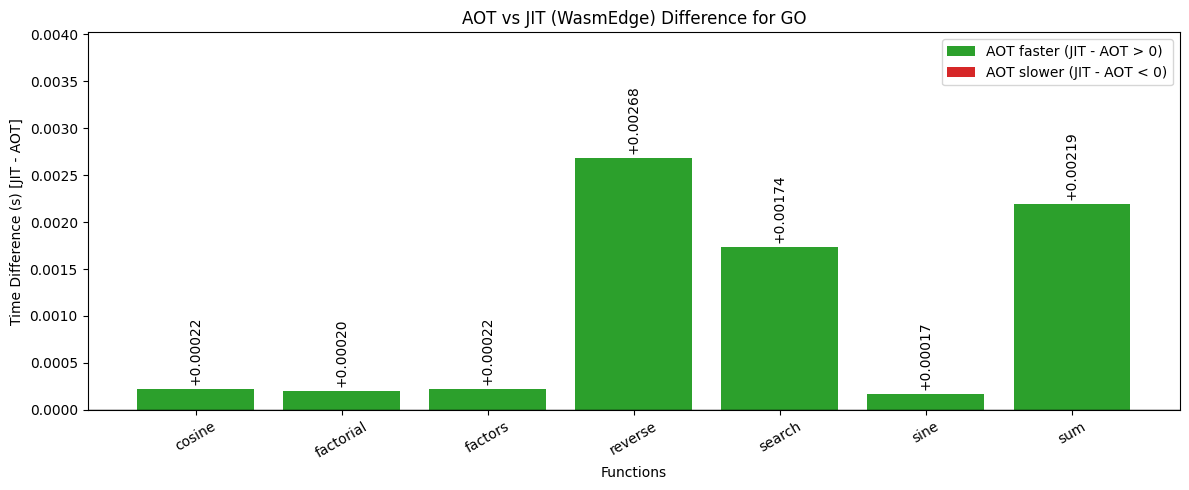

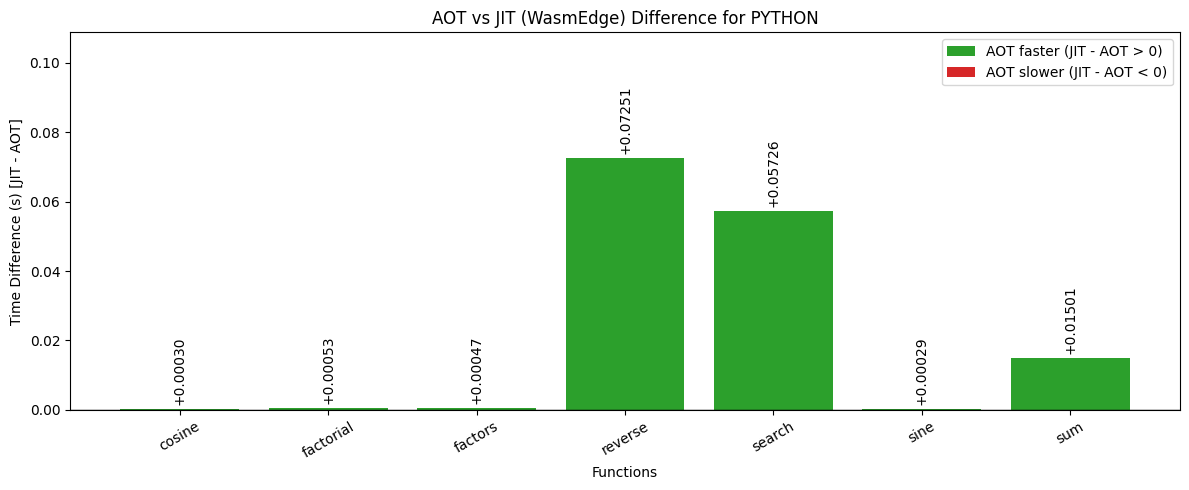

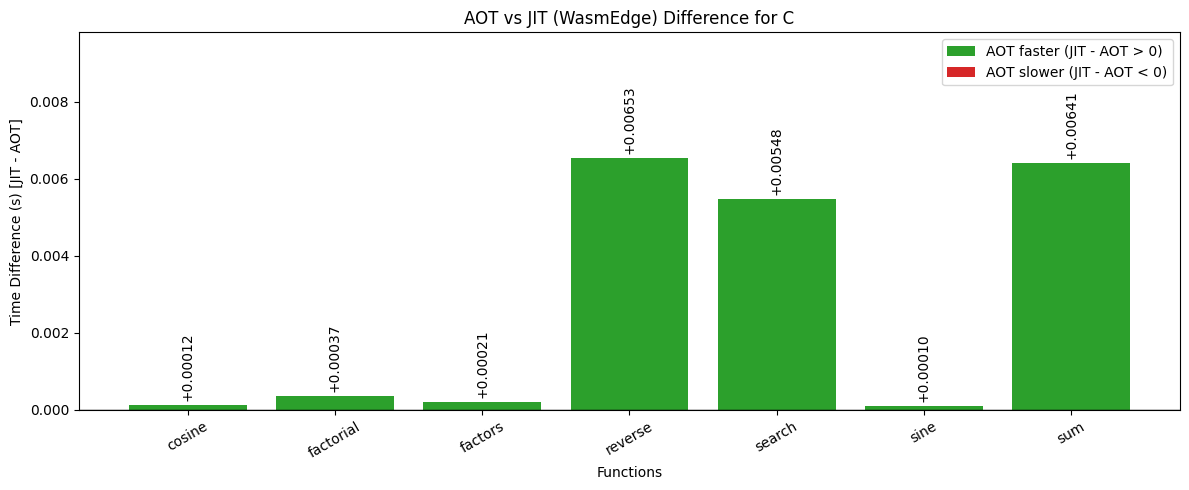

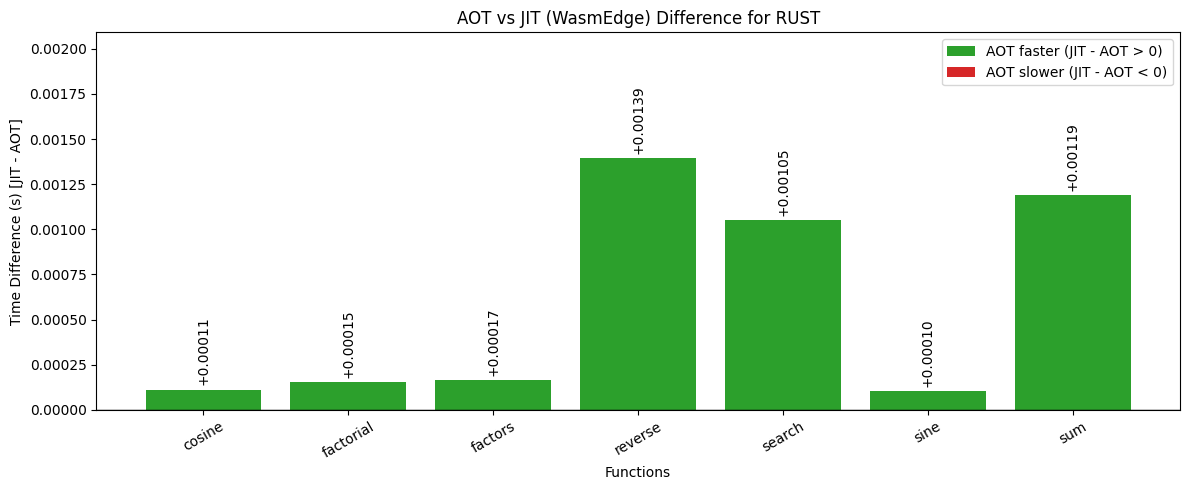

In [ ]:
# Compare AOT vs JIT (WasmEdge) execution times and plot differences
# Difference = JIT_wasmedge - AOT_compiled (positive => AOT faster)

# Load compiled AOT results
compiled_csv_path = "benchmarking_results/compiled_wasmedge_benchmarks.csv"
compiled_df = pd.read_csv(compiled_csv_path)

# Prepare JIT WasmEdge (non-AOT) results from execution_data
jit_df = execution_data[execution_data["Env"] == "wasmedge"][[
    "language", "function", "execution_time"
]].rename(columns={"execution_time": "jit_time"})

# Prepare AOT from compiled_df
aot_df = compiled_df[["language", "function", "execution_time"]].rename(columns={"execution_time": "aot_time"})

# Merge per language/function
merged = pd.merge(jit_df, aot_df, on=["language", "function"], how="inner")
# Exclude sort for consistency
merged = merged[merged["function"] != "sort"]

if merged.empty:
    print("No matching AOT and JIT results to compare.")
else:
    for lang in LANGUAGES:
        sub = merged[merged["language"] == lang].copy()
        if sub.empty:
            continue
        sub = sub.sort_values(by="function")
        sub["diff"] = sub["jit_time"] - sub["aot_time"]

        functions = sub["function"].tolist()
        x = np.arange(len(functions))

        plt.figure(figsize=(12, 5))

        bars = plt.bar(x, sub["diff"].values, color=["#2ca02c" if d > 0 else "#d62728" for d in sub["diff"].values])

        # Zero baseline for clarity
        plt.axhline(0, color="black", linewidth=1)

        plt.xlabel("Functions")
        plt.ylabel("Time Difference (s) [JIT - AOT]")
        plt.title(f"AOT vs JIT (WasmEdge) Difference for {lang.upper()}")
        plt.xticks(x, functions, rotation=30)

        # Headroom
        y_abs_max = float(np.nanmax(np.abs(sub["diff"].values))) if len(sub) else 0.0
        if y_abs_max > 0:
            plt.ylim(0, y_abs_max * 1.5)

        # Labels on bars
        labels = [f"{v:+.5f}" for v in sub["diff"].values]
        plt.bar_label(bars, labels=labels, padding=3, rotation=90)

        # Legend: color meaning
        from matplotlib.patches import Patch
        legend_handles = [
            Patch(facecolor="#2ca02c", label="AOT faster (JIT - AOT > 0)"),
            Patch(facecolor="#d62728", label="AOT slower (JIT - AOT < 0)"),
        ]
        plt.legend(handles=legend_handles, loc="upper right")

        plt.tight_layout()
        plt.show()


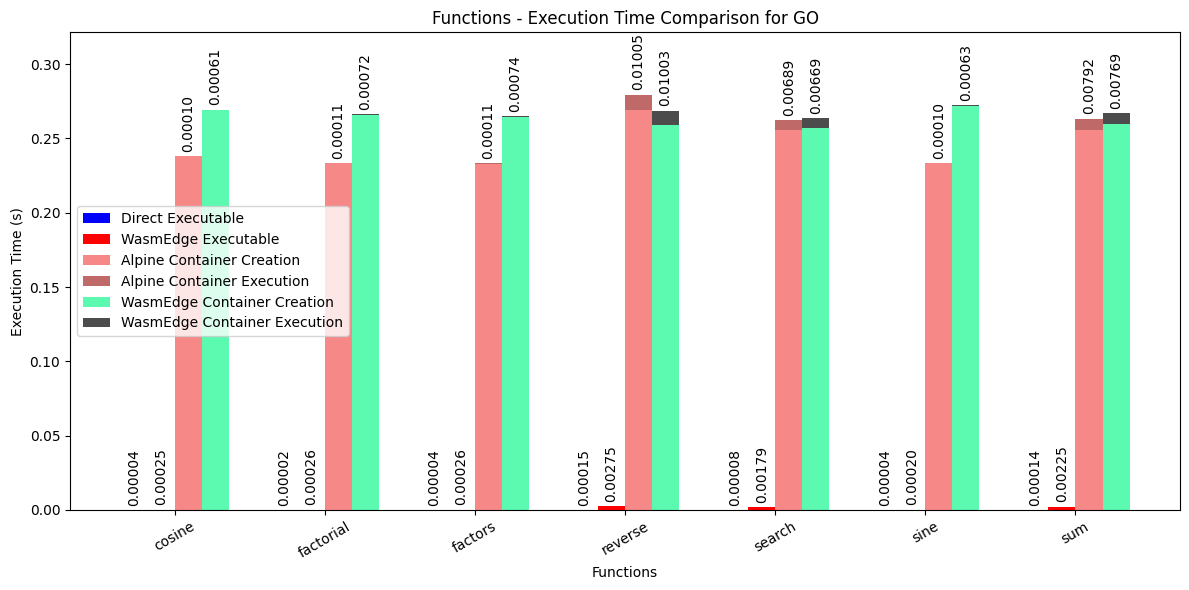

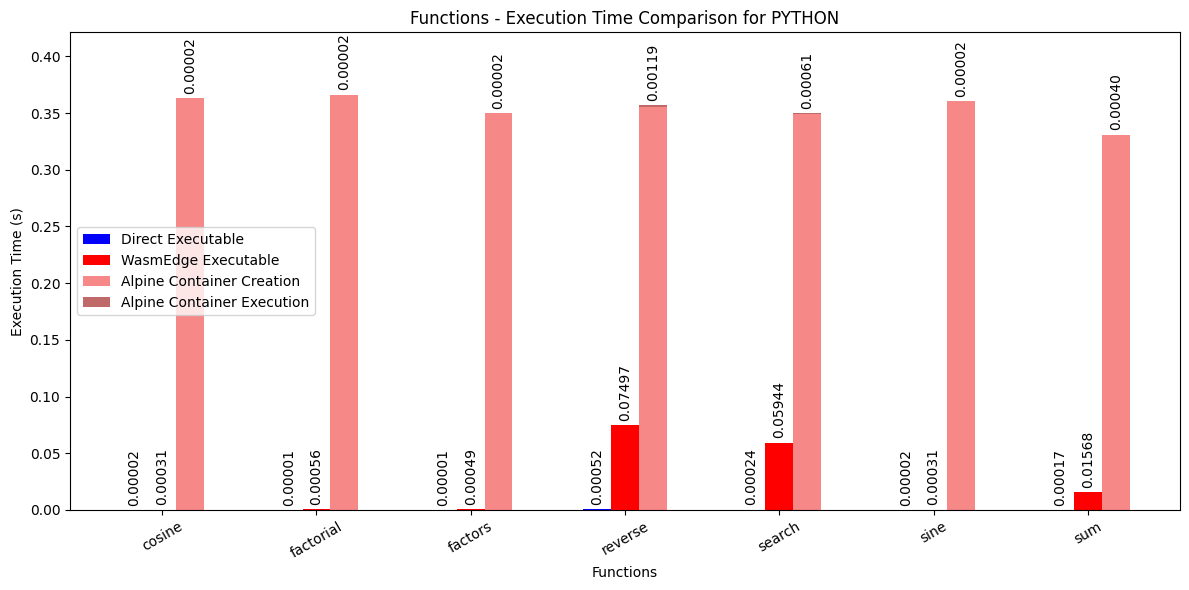

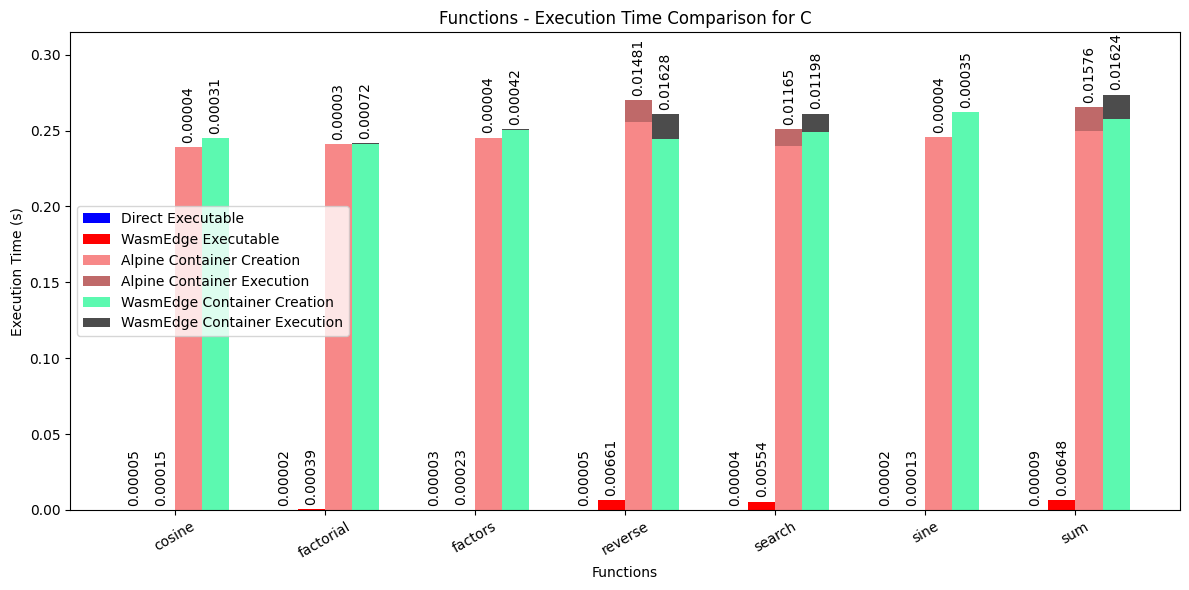

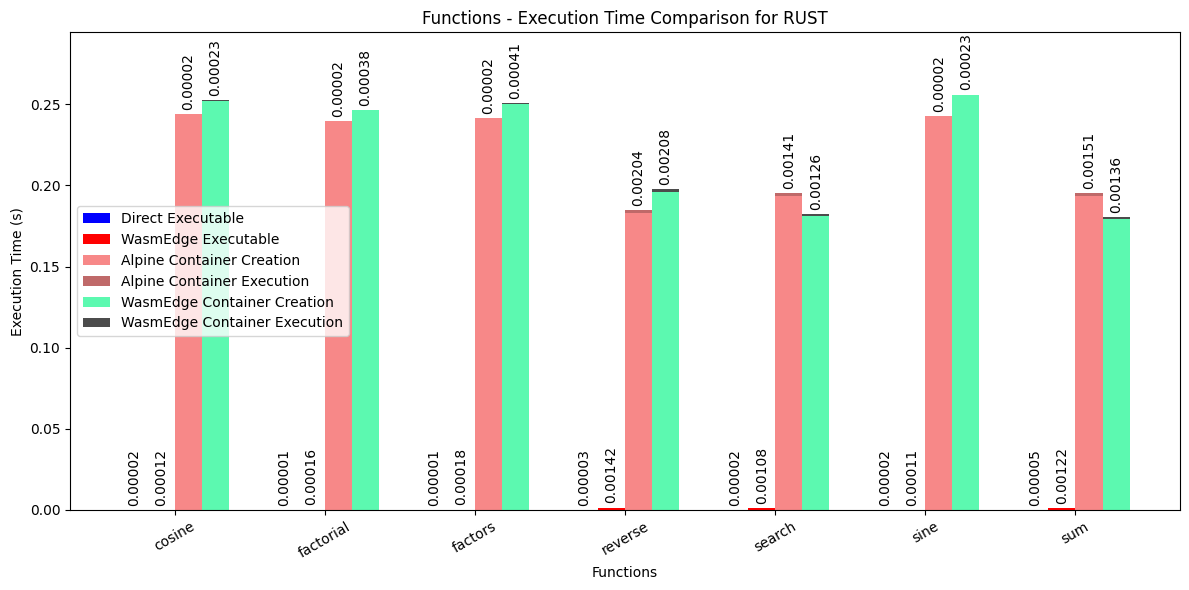

In [ ]:
# direct_executable = execution_data[execution_data['Env'] == 'executable']
# # print(direct_executable)
# print(direct_executable[direct_executable['language'] == 'go'])
# wasmedge_executable = execution_data[execution_data['Env'] == 'wasmedge']
# # print(wasmedge_executable)
# particular_lang = wasmedge_executable[wasmedge_executable['language'] == 'go']
# print(wasmedge_executable[wasmedge_executable['language'] == 'go'])
# print(particular_lang['execution_time'])
# container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")
execution_data = pd.read_csv("benchmarking_results/executable_benchmark_results_first.csv")
container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")
# print(container_data)

# Create visualizations for each category and language combination

for lang in LANGUAGES:
    exec_data = execution_data[execution_data["language"] == lang]
    cont_data = container_data[container_data["language"] == lang]
    
    # Filter by category
    # exec_data = exec_data[exec_data["category"] == category]
    # cont_data = cont_data[cont_data["category"] == category]
    
    if exec_data.empty and cont_data.empty:
        continue

    
    
    # Split by environment
    direct_exec = exec_data[exec_data["Env"] == "executable"].sort_values(by="function")
    wasmtime_exec = exec_data[exec_data["Env"] == "wasmtime"].sort_values(by="function")

    # print(wasmtime_exec)
    wasmedge_exec = exec_data[exec_data["Env"] == "wasmedge"].sort_values(by="function")

    alpine_cont = cont_data[cont_data["Env"] == "alpine"].sort_values(by="function")
    wasmedge_cont = cont_data[cont_data["Env"] == "wasmedge/slim-runtime"].sort_values(by="function")

    # if category == "Array":
    direct_exec = direct_exec[direct_exec["function"] != "sort"]
    wasmedge_exec = wasmedge_exec[wasmedge_exec["function"] != "sort"]
    alpine_cont = alpine_cont[alpine_cont["function"] != "sort"]
    wasmedge_cont = wasmedge_cont[wasmedge_cont["function"] != "sort"]


    # Get unique functions for this category/lang combination
    all_functions = set()
    for df in [direct_exec, wasmedge_exec, alpine_cont, wasmedge_cont]:
        if not df.empty:
            all_functions.update(df["function"].tolist())
    
    functions = sorted(list(all_functions))
    if not functions:
        continue
        
    x = np.arange(len(functions))
    bar_width = 0.18

    plt.figure(figsize=(12, 6))

    # Build active series list with stacked info for containers
    def values_for(df, column):
        mapped = {f: v for f, v in zip(df["function"], df[column])}
        vals = [mapped.get(f, np.nan) for f in functions]
        return np.nan_to_num(vals, nan=0.0)

    series = []  # (label, type, colors, data_arrays)
    if not direct_exec.empty:
        series.append(("Direct Executable", "single", ["blue"], [values_for(direct_exec, "execution_time")]))
    if not wasmtime_exec.empty:
        series.append(("Wasmtime Executable", "single", ["green"], [values_for(wasmtime_exec, "execution_time")]))
    if not wasmedge_exec.empty:
        series.append(("WasmEdge Executable", "single", ["red"], [values_for(wasmedge_exec, "execution_time")]))
    if not alpine_cont.empty:
        series.append(("Alpine Container", "stacked", ["#f56868c9", "brown"], [values_for(alpine_cont, "container_creation"), values_for(alpine_cont, "avg_execution_time")]))
    if not wasmedge_cont.empty:
        series.append(("WasmEdge Container", "stacked", ["#31f89bca", "black"], [values_for(wasmedge_cont, "container_creation"), values_for(wasmedge_cont, "avg_execution_time")]))

    k = len(series)
    if k == 0:
        plt.close()
        continue

    # Center the group and space bars evenly regardless of which series exist
    offsets = (np.arange(k) - (k - 1) / 2.0) * bar_width

    # Plot each series and compute y-limit headroom
    plotted = {}
    y_max = 0.0
    for j, (label, kind, colors, data_arrays) in enumerate(series):
        xpos = x + offsets[j]
        if kind == "single":
            vals = data_arrays[0]
            y_max = max(y_max, float(np.nanmax(vals)) if len(vals) else 0.0)
            plotted[label] = plt.bar(xpos, vals, bar_width, label=label, color=colors[0])
        else:
            base = data_arrays[0]
            top = data_arrays[1]
            totals = np.array(base) + np.array(top)
            y_max = max(y_max, float(np.nanmax(totals)) if len(totals) else 0.0)
            # bottom bar: container creation
            plt.bar(xpos, base, bar_width, label=f"{label} Creation", color=colors[0])
            # top bar: execution on top of creation
            plotted[label] = plt.bar(xpos, top, bar_width, bottom=base, label=f"{label} Execution", color=colors[1], alpha=0.7)

    # Labels and style
    plt.xlabel("Functions")
    plt.ylabel("Execution Time (s)")
    plt.title(f"Functions - Execution Time Comparison for {lang.upper()}")
    plt.xticks(x, functions, rotation=30)
    if y_max > 0:
        plt.ylim(0, y_max * 1.15)
    plt.legend()

    # Add values on the visible top bars
    for label, bar in plotted.items():
        heights = [p.get_height() for p in bar]
        labels = [f"{h:.5f}" if h > 0 else "" for h in heights]
        plt.bar_label(bar, labels=labels, padding=3, rotation=90)

    plt.tight_layout()
    plt.show()

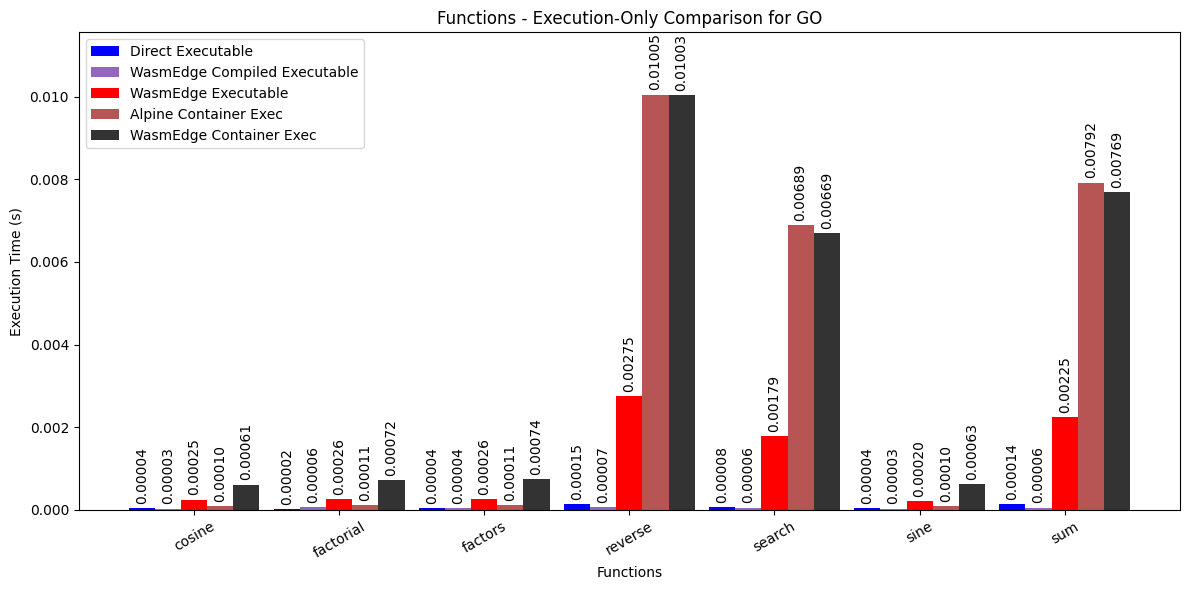

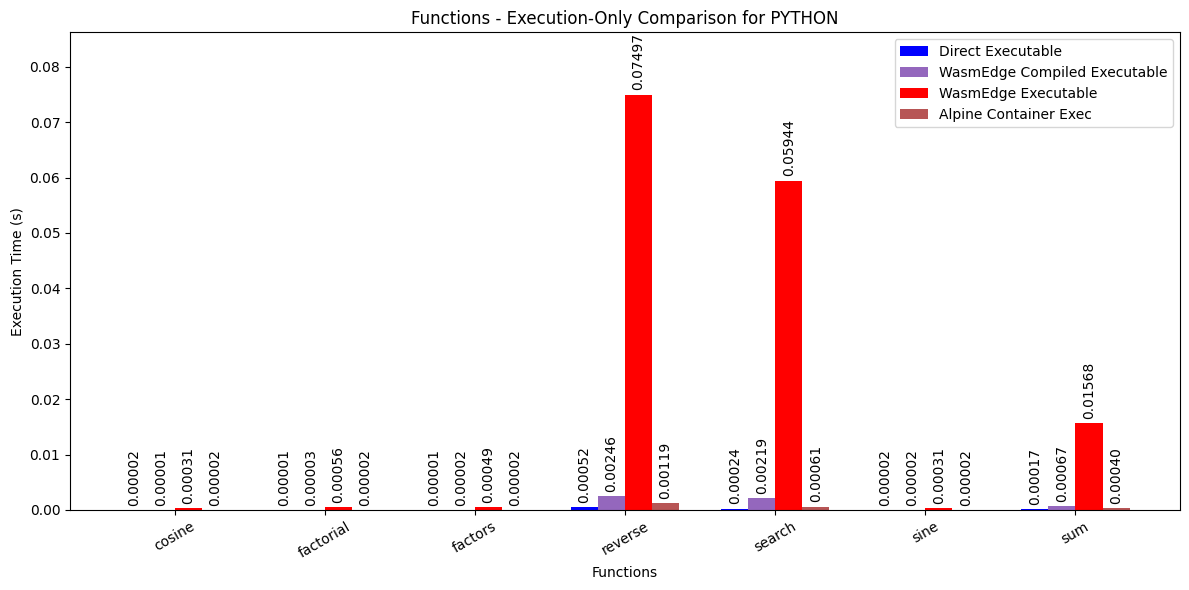

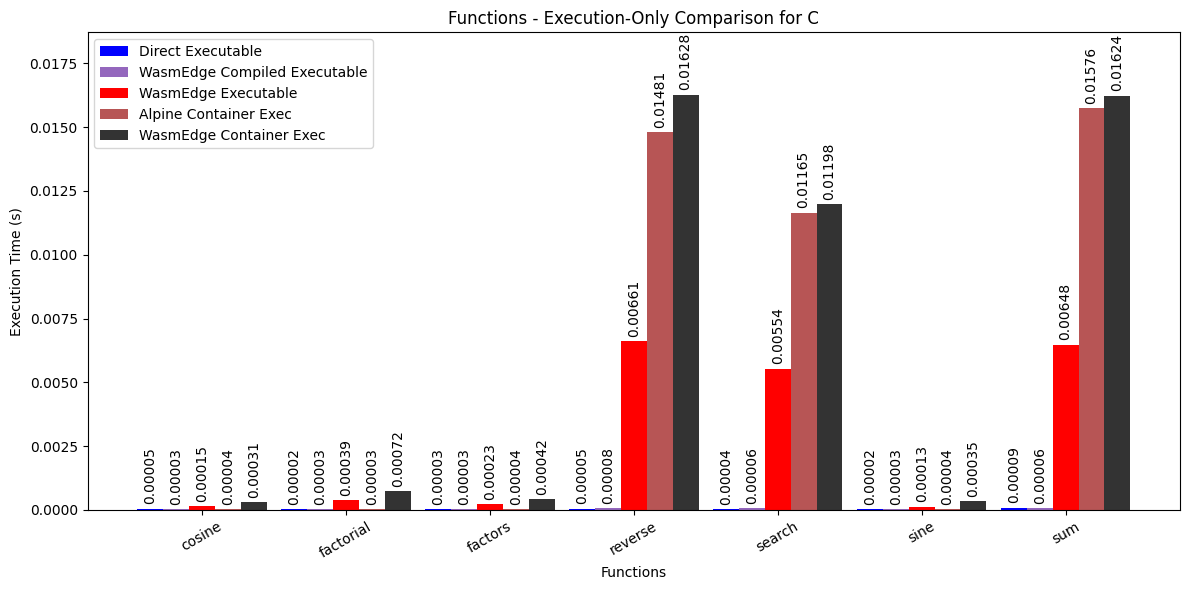

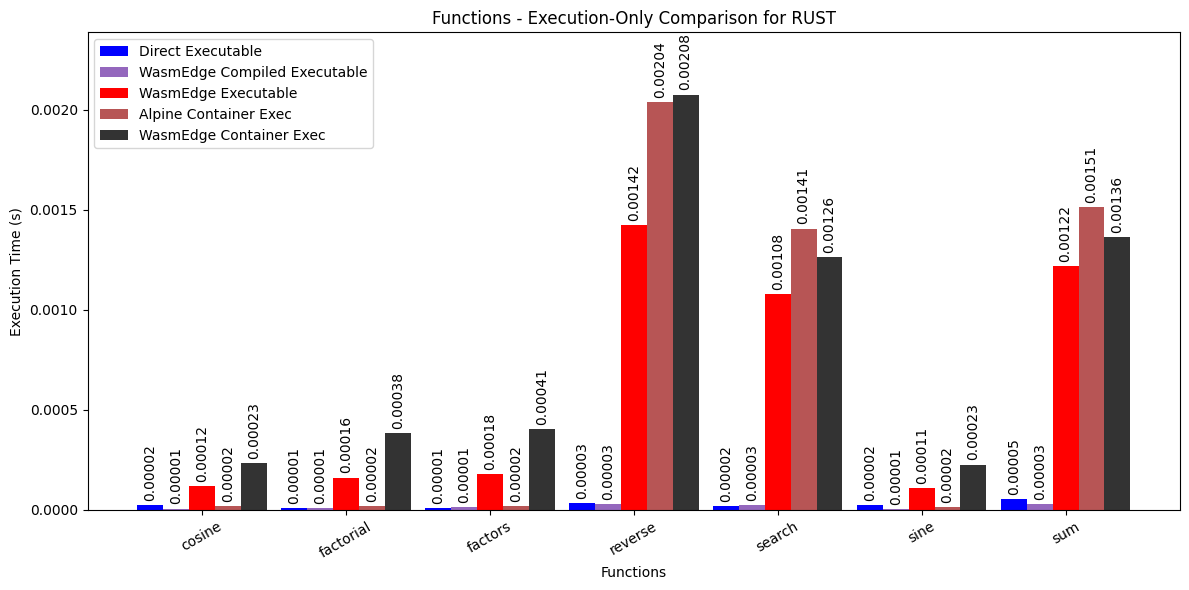

In [ ]:
# Execution-only bar chart (no container creation time)
for lang in LANGUAGES:
    exec_data = execution_data[execution_data["language"] == lang]
    cont_data = container_data[container_data["language"] == lang]

    if exec_data.empty and cont_data.empty:
        continue

    # Split by environment
    direct_exec = exec_data[exec_data["Env"] == "executable"].sort_values(by="function")
    wasmtime_exec = exec_data[exec_data["Env"] == "wasmtime"].sort_values(by="function")
    wasmedge_exec = exec_data[exec_data["Env"] == "wasmedge"].sort_values(by="function")

    alpine_cont = cont_data[cont_data["Env"] == "alpine"].sort_values(by="function")
    wasmedge_cont = cont_data[cont_data["Env"] == "wasmedge/slim-runtime"].sort_values(by="function")

    # Exclude sort for consistency with prior chart
    direct_exec = direct_exec[direct_exec["function"] != "sort"]
    wasmtime_exec = wasmtime_exec[wasmtime_exec["function"] != "sort"]
    wasmedge_exec = wasmedge_exec[wasmedge_exec["function"] != "sort"]
    alpine_cont = alpine_cont[alpine_cont["function"] != "sort"]
    wasmedge_cont = wasmedge_cont[wasmedge_cont["function"] != "sort"]

    # Collect unique functions
    all_functions = set()
    for df in [direct_exec, wasmtime_exec, wasmedge_exec, alpine_cont, wasmedge_cont]:
        if not df.empty:
            all_functions.update(df["function"].tolist())

    functions = sorted(list(all_functions))
    if not functions:
        continue

    x = np.arange(len(functions))
    bar_width = 0.18

    plt.figure(figsize=(12, 6))

    # Build active series and compute centered offsets dynamically
    series = []

    # 1) Direct executable
    if not direct_exec.empty:
        series.append(("Direct Executable", direct_exec, "execution_time", "blue", 1.0))

    # 2) WasmEdge Compiled (AOT) immediately after Direct
    try:
        compiled_df
    except NameError:
        try:
            compiled_df = pd.read_csv("benchmarking_results/compiled_wasmedge_benchmarks.csv")
        except Exception:
            compiled_df = None
    if compiled_df is not None:
        compiled_lang = compiled_df[compiled_df["language"] == lang].sort_values(by="function")
        compiled_lang = compiled_lang[compiled_lang["function"] != "sort"]
        if not compiled_lang.empty:
            series.append(("WasmEdge Compiled Executable", compiled_lang, "execution_time", "#9467bd", 1.0))

    # 3) Remaining series
    if not wasmtime_exec.empty:
        series.append(("Wasmtime Executable", wasmtime_exec, "execution_time", "green", 1.0))
    if not wasmedge_exec.empty:
        series.append(("WasmEdge Executable", wasmedge_exec, "execution_time", "red", 1.0))
    if not alpine_cont.empty:
        series.append(("Alpine Container Exec", alpine_cont, "avg_execution_time", "brown", 0.8))
    if not wasmedge_cont.empty:
        series.append(("WasmEdge Container Exec", wasmedge_cont, "avg_execution_time", "black", 0.8))

    k = len(series)
    if k == 0:
        plt.close()
        continue

    # Center the group and space bars evenly regardless of how many series are present
    offsets = (np.arange(k) - (k - 1) / 2.0) * bar_width

    # Helper to align values with the function order
    def values_for(df, column):
        mapped = {f: v for f, v in zip(df["function"], df[column])}
        vals = [mapped.get(f, np.nan) for f in functions]
        return np.nan_to_num(vals, nan=0.0)

    bars = []
    y_max = 0.0
    for j, (label, df, col, color, alpha) in enumerate(series):
        vals = values_for(df, col)
        if len(vals):
            y_max = max(y_max, float(np.nanmax(vals)))
        bars.append((label, plt.bar(x + offsets[j], vals, bar_width, label=label, color=color, alpha=alpha)))

    # Labels and style
    plt.xlabel("Functions")
    plt.ylabel("Execution Time (s)")
    plt.title(f"Functions - Execution-Only Comparison for {lang.upper()}")
    plt.xticks(x, functions, rotation=30)
    if y_max > 0:
        plt.ylim(0, y_max * 1.15)
    plt.legend()

    # Add values on bars (skip zeros to reduce clutter)
    for label, bar in bars:
        heights = [p.get_height() for p in bar]
        labels = [f"{h:.5f}" if h > 0 else "" for h in heights]
        plt.bar_label(bar, labels=labels, padding=3, rotation=90)

    plt.tight_layout()
    plt.show()


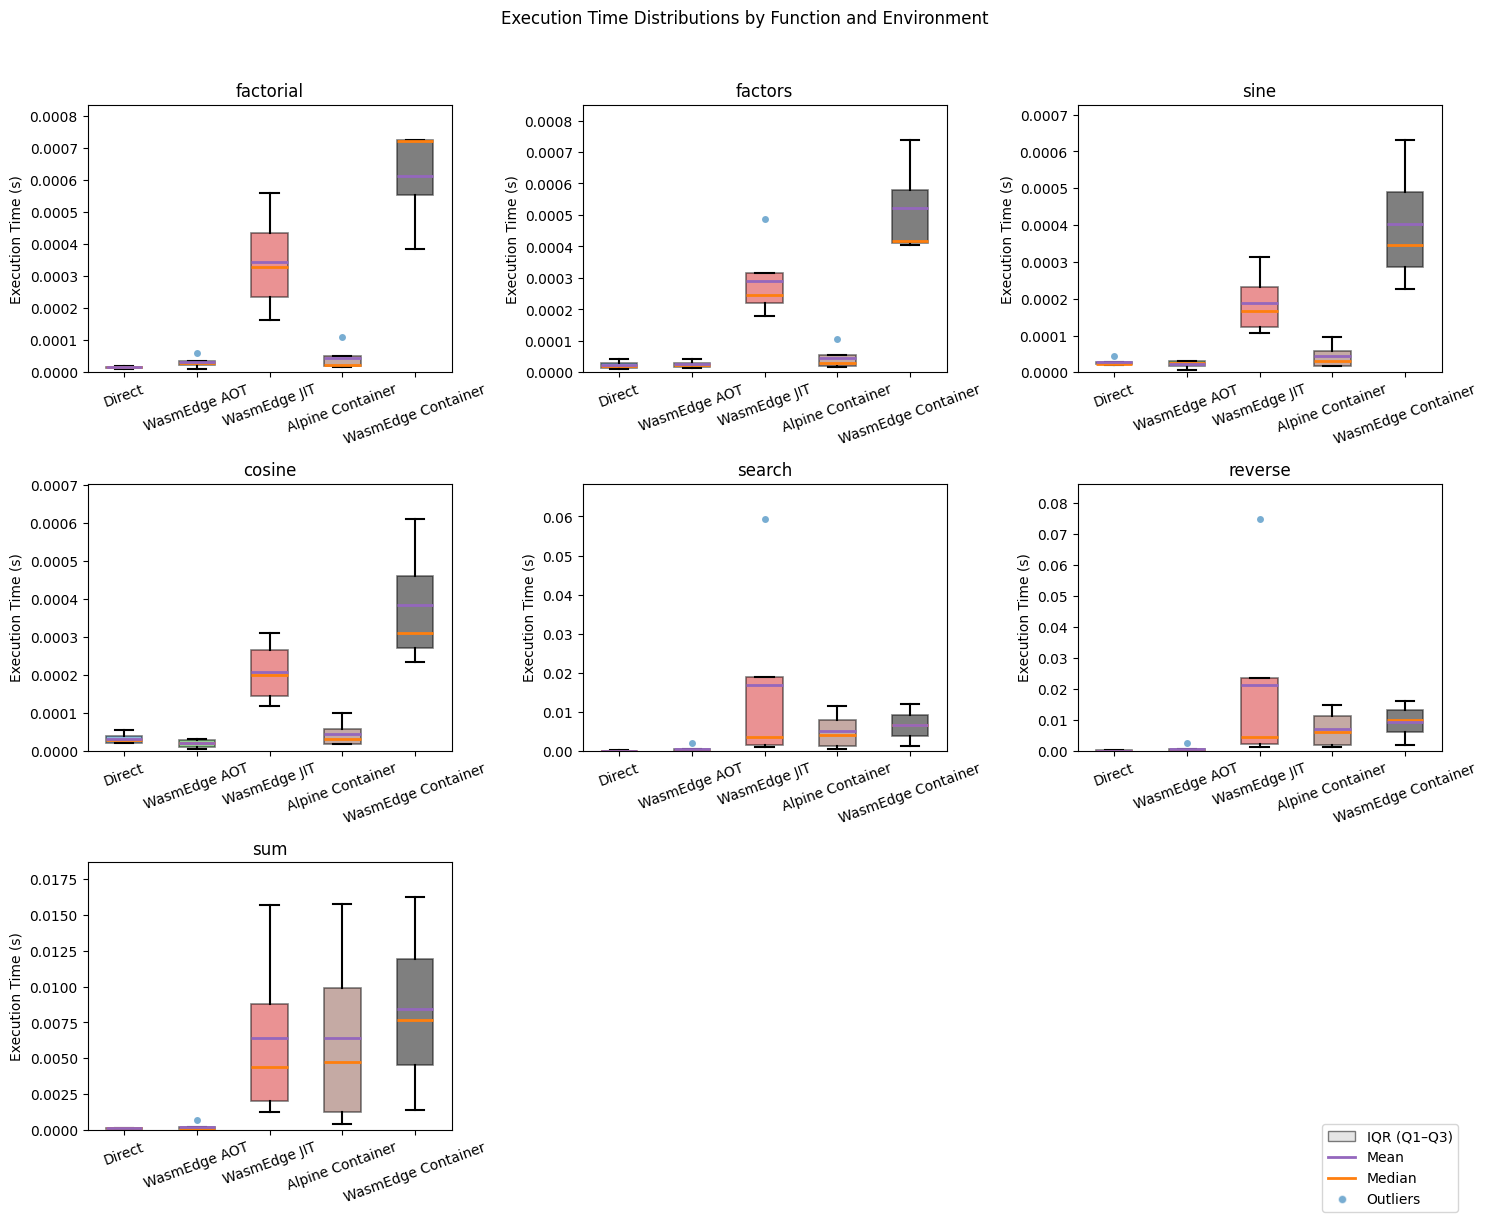

In [ ]:
# Grid of box plots: per function, x-axis = environment, y-axis = execution time
# Uses execution-only times: direct/wasmtime/wasmedge executables and container avg_execution_time

# Prepare environment order and pretty labels (insert WasmEdge Compiled after Direct)
# Ensure compiled_df is loaded
try:
    compiled_df
except NameError:
    try:
        compiled_df = pd.read_csv("benchmarking_results/compiled_wasmedge_benchmarks.csv")
    except Exception:
        compiled_df = None

ENV_SPECS = [
    ("executable", "Direct"),
    ("wasmedge_compiled", "WasmEdge AOT"),
    ("wasmtime", "Wasmtime"),
    ("wasmedge", "WasmEdge JIT"),
    ("alpine", "Alpine Container"),
    ("wasmedge/slim-runtime", "WasmEdge Container"),
]

# Prepare list of functions to plot (exclude sort)
funcs = [f for f in FUNCTIONS if f != "sort"]
num_funcs = len(funcs)
if num_funcs == 0:
    print("No functions to plot.")
else:
    # Choose a near-square grid
    cols = int(np.ceil(np.sqrt(num_funcs)))
    rows = int(np.ceil(num_funcs / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.2 * rows), squeeze=False, sharey=False)

    for idx, func in enumerate(funcs):
        r, c = divmod(idx, cols)
        ax = axes[r][c]

        data_lists = []
        labels = []
        for env_key, env_label in ENV_SPECS:
            if env_key in ("executable", "wasmtime", "wasmedge"):
                vals = execution_data[(execution_data["function"] == func) & (execution_data["Env"] == env_key)]["execution_time"].values
            elif env_key == "wasmedge_compiled" and compiled_df is not None:
                vals = compiled_df[(compiled_df["function"] == func)]["execution_time"].values
            else:
                vals = container_data[(container_data["function"] == func) & (container_data["Env"] == env_key)]["avg_execution_time"].values
            vals = vals[~np.isnan(vals)] if len(vals) else vals
            if len(vals):
                data_lists.append(vals)
                labels.append(env_label)

        if data_lists:
            # Standardize boxplot line styles for consistent legend meanings
            medianprops = dict(color="#ff7f0e", linewidth=2)
            meanprops = dict(color="#9467bd", linewidth=2, linestyle='-')
            whiskerprops = dict(color="black", linewidth=1.5)
            capprops = dict(color="black", linewidth=1.5)
            boxprops = dict(edgecolor="black", linewidth=1.2)
            flierprops = dict(marker='o', markerfacecolor="#1f77b4", markersize=5, alpha=0.6, markeredgecolor='none')

            bp = ax.boxplot(
                data_lists,
                tick_labels=labels,
                patch_artist=True,
                showmeans=True,
                meanline=True,
                meanprops=meanprops,
                medianprops=medianprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
                boxprops=boxprops,
                flierprops=flierprops,
            )
            # Simple coloring for visibility of IQR boxes
            colors = ["#1f77b4", "#2ca02c", "#d62728", "#8c564b", "#000000"]
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
            # Per-subplot ylim with headroom
            local_max = max([np.nanmax(v) for v in data_lists])
            if local_max > 0:
                ax.set_ylim(0, float(local_max) * 1.15)
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_xticks([])

        ax.set_title(f"{func}")
        # ax.set_xlabel("Environment")
        ax.set_ylabel("Execution Time (s)")
        ax.tick_params(axis='x', rotation=20)

    # Hide any unused subplots
    for j in range(num_funcs, rows * cols):
        r, c = divmod(j, cols)
        axes[r][c].axis('off')

    # Figure-level legend explaining boxplot elements in bottom-right
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor="#cccccc", edgecolor="black", alpha=0.5, label="IQR (Q1–Q3)"),
        Line2D([0], [0], color="#9467bd", lw=2, label="Mean"),
        Line2D([0], [0], color="#ff7f0e", lw=2, label="Median"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor="#1f77b4", markersize=6, alpha=0.6, label="Outliers"),
    ]
    fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(0.98, 0.02))

    fig.suptitle("Execution Time Distributions by Function and Environment")
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()
